In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tif
from tqdm.notebook import tqdm
from copy import deepcopy

In [3]:
from sladsnet.input_params import ERDInputParams, GeneralInputParams, SimulatedSampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.simulation_base import SimulatedSample
from sladsnet.code.sampling import run_sampling


###  Step 1: Change the ERD model path and c value as desired. The current script uses the training image 93. The optimal c value for this training model is 16.

Note: I am using pathlib for the paths, but strings should work just fine.

### Step 1: Supply the path for the test image. The image should be a tif normalized to 0-1 range.

True


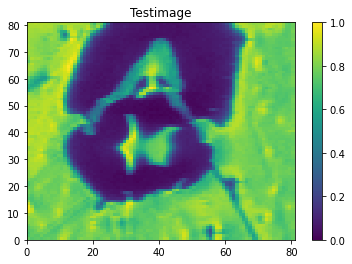

In [4]:

base_path = Path.cwd().parent
#train_path = base_path / 'ResultsAndData/TrainingData/93/Images/'
test_path = base_path / 'ResultsAndData/TestingImages/TestingImageSet_91'
print(test_path.exists())
test_img_path = list((test_path).glob('*.tif'))[0]
test_img = tif.imread(test_img_path)

plt.pcolormesh(test_img)
plt.colorbar()
plt.title('Testimage')
plt.show()

### Step 2: Create a measurement interface. In this case, since we are using 

- The measurement interface is decoupled from the rest of the code so that the code does not care how the measurements are being performed, only that they are. This should make a plug and play interface possible.
- In this case, since we are using a simulated image, we create a "TransmissionSimulationMeasurementInterface"

In [5]:
measurement_interface = TransmissionSimulationMeasurementInterface(test_img)

### Step 3: Set the "c_value", and the "stop_ratio", and the "store_results_percentage".
- The c_value controls the size of the window we consider to update the ERD for each pixel. Small c_value=large window, and vice versa. For larger c_values, the measurements tend to clump together, while, for smaller c_values, the calculation can be more expensive. I am using a c_value of 16, but we actually optimize this during the training step.
- The stop_ratio indicates when to stop sampling. Stop ratio of 0.2 = 20% sampling.


In [11]:
c_value = 16
stop_ratio = 0.2

### Step 4: Accelerate the calculation:
Parameters of interest are: 

**inner_batch_size**
- With inner_batch_size > 1, we select a batch of points (instead of just one point) to measure at every step.

**calculate_full_erd_per_step**
- If "calculate_full_erd_per_step" is set to False, we update the ERDs for only the neighborhood of the measurement, not the entire reconstructed image. 

**affected_neighbors_window_min** and **affected_neighbors_window_max**
- This sets the minimum and maximum value of the both the window size for the ERD calculation (see setp 3 above) and the window size for the ERD update. If these are set to large values, then the computation is more accurate, but slower.

**full_erd_recalculation_frequency**
- While using a small window for the ERD updates is much faster than a full recalculation, this tends to produce local minimas. To alleviate this, we calculate the ERD for the full image after every N measurements.

In [12]:
inner_batch_size = 5
calculate_full_erd_per_step = False
# These are in scan steps and not in precentages of the sample measured

affected_neighbors_window_min = 5
affected_neighbors_window_max = 20
full_erd_recalculation_frequency = 20

In [13]:
sim_params = SimulatedSampleParams(test_img, simulation_type='visualize_erd',
                                   stop_ratio=stop_ratio,
                                   inner_batch_size=inner_batch_size)
erd_params = ERDInputParams(c_value,
                            calculate_full_erd_per_step=calculate_full_erd_per_step,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
gen_params = GeneralInputParams()

In [14]:
sample = SimulatedSample(sample_params=sim_params,
                         measurement_interface=measurement_interface, 
                         erd_params=erd_params,
                         general_params=gen_params, 
                         erd_model=None)

### Step 5: the store_results_percentage indicates how often we want to store the results in a "Results" object. This is useful for later visualization.

In [15]:
store_results_percentage = 1

In [16]:
results = Result()

In [17]:
run_sampling(sample, results=results, results_frequency_percentage=store_results_percentage, disable_progress_bar=False)

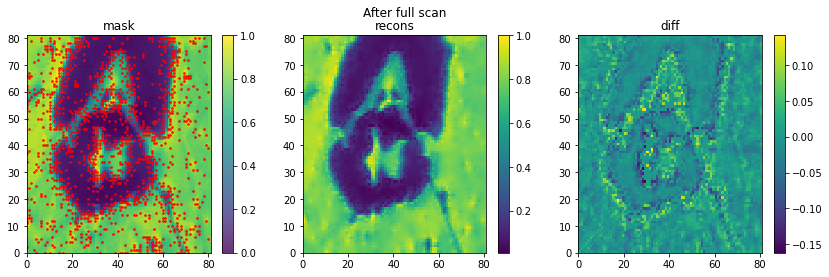

In [18]:
fig, axs = plt.subplots(1, 3, figsize=[14, 4])
plt.subplot(1, 3, 1)

plt.pcolormesh(measurement_interface.image)
plt.scatter(sample.measurement_info.measured_idxs[:, 1],
            sample.measurement_info.measured_idxs[:, 0],
            alpha=0.8, color='red', s=3)
plt.colorbar()
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(sample.recon_image)
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
plt.pcolormesh(measurement_interface.image - sample.recon_image)
plt.colorbar()
plt.title('diff')
plt.suptitle('After full scan')
plt.show()

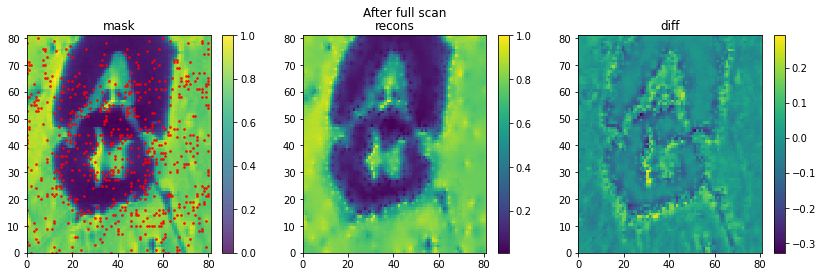

In [19]:
midxs = np.where(results.outputs.masks[10])

fig, axs = plt.subplots(1, 3, figsize=[14, 4])
plt.subplot(1, 3, 1)

plt.pcolormesh(measurement_interface.image)
plt.scatter(midxs[0],
            midxs[1],
            alpha=0.8, color='red', s=3)
plt.colorbar()
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[10])
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
plt.pcolormesh(measurement_interface.image - results.outputs.recons[10])
plt.colorbar()
plt.title('diff')
plt.suptitle('After full scan')
plt.show()